In [60]:
import GAN.models as models
import ganja.io as io
import ganja.utils as utils
import ganja.plotting as plotting
import ganja.preprocessing as preprocessing
import ganja.plotting as plotting

import json


import matplotlib
matplotlib.style.use('seaborn-poster')


In [61]:
from  keras.models import load_model

In [114]:
target = 'log/unnorm_cond_noise_l2_sm_x2/'


STOCHASTIC_LAYER=False
with open(target+'/config.json') as fin:
    training_parameters = json.loads(fin.read())
    
globals().update(training_parameters)

training_parameters

{'BASE_FOLDER': '/scratch/snx3000/musella/ganja/split',
 'BATCH': True,
 'BATCH_SIZE': 256,
 'COMPRESSED': False,
 'COND_VARIABLES': ['ptGen', 'etaGen', 'phiGen', 'nPU'],
 'DECODING_LAST_PLATEAU': 2,
 'EPOCHS': 20,
 'IMG_SIZE': 32,
 'LOSS': 'soft_mask_mean_squared_error',
 'MAX_ENCODING': 16,
 'MOMENTS': 'moments_nov2.npz',
 'MONITOR_DIR': 'log/unnorm_cond_noise_l2_sm_x2',
 'NFILTERS': 16,
 'NOISE_DIM': 32,
 'NTRAIN': 4,
 'NVALID': 1,
 'N_ENCODING': 6,
 'SOFT_MASK': True,
 'STDEV_REGULARZATION': 0.02,
 'STOCHASTIC_LAYER': False,
 'VALID_FRAC': 1,
 'VERSION': 'nov2_v3',
 'WEIGHTS': 'weights_nov2_pt.npy',
 'WIN_MIN': 0}

In [115]:
# metrics = df.read_csv(target+'/')

In [116]:
import os

with open(BASE_FOLDER+'/'+VERSION+'/train_valid_test.json') as fin:
    split_map = json.loads(fin.read())


In [117]:
test_inputs = {os.path.join(BASE_FOLDER,VERSION) : split_map['test'][:1]}

moments = np.load(MOMENTS.format(VERSION=VERSION))
reco_moments = moments['reco_mean'],moments['reco_std'],0.02
gen_moments = moments['gen_mean'],moments['gen_std'],0.02

weights = np.load(WEIGHTS.format(VERSION=VERSION),encoding='latin1')
weights = weights[0],weights[2:],weights[1]

In [118]:

test_reader = io.Reader(test_inputs,weights,compressed=COMPRESSED,cond_names=COND_VARIABLES,noise_dim=NOISE_DIM,
                       aux_noise=STOCHASTIC_LAYER)#,gen_moments=gen_moments)


In [119]:
ret = test_reader.get()
X_test,y_test = ret[0:2]
w_test = ret.pop(-1)

if test_reader.aux_noise:
    ret[-1] = ret[-1][:,:32,:32]
inputs_test = [X_test[:,:32,:32]]+ret[2:]

#X_unnorm = preprocessing.unnormalize(X_test,*gen_moments)
X_unnorm = X_test

In [120]:
previous = None

In [121]:
weights = ! ls -t $target/*.hdf5
print("\n".join(weights))

latest = weights[0]

log/unnorm_cond_noise_l2_sm_x2//model-14.hdf5
log/unnorm_cond_noise_l2_sm_x2//model-02.hdf5
log/unnorm_cond_noise_l2_sm_x2//model-01.hdf5
log/unnorm_cond_noise_l2_sm_x2//model-00.hdf5


In [122]:
import keras.backend as K
import ganja.losses

from GAN.unet import stochastic_threshold
if latest != previous:
    print('loading model '+latest)
    model = load_model(latest,custom_objects=dict(stochastic_threshold=stochastic_threshold))
    previous = latest

loading model log/unnorm_cond_noise_l2_sm_x2//model-14.hdf5


In [123]:
model.loss

'soft_mask_mean_squared_error'

In [124]:
run_inputs = [ x[:100000] for x in inputs_test ]

y_pred = model.predict(run_inputs)

if y_pred.shape[-1] >1:
    y_pred_val,y_pred_prob = y_pred[:,:,:,0:1],y_pred[:,:,:,1:]
else:
    y_pred_val,y_pred_prob = y_pred,None

In [125]:
!mkdir -p plots/$target

In [126]:
sample = np.random.choice(np.arange(0,y_pred_val.shape[0]),4)

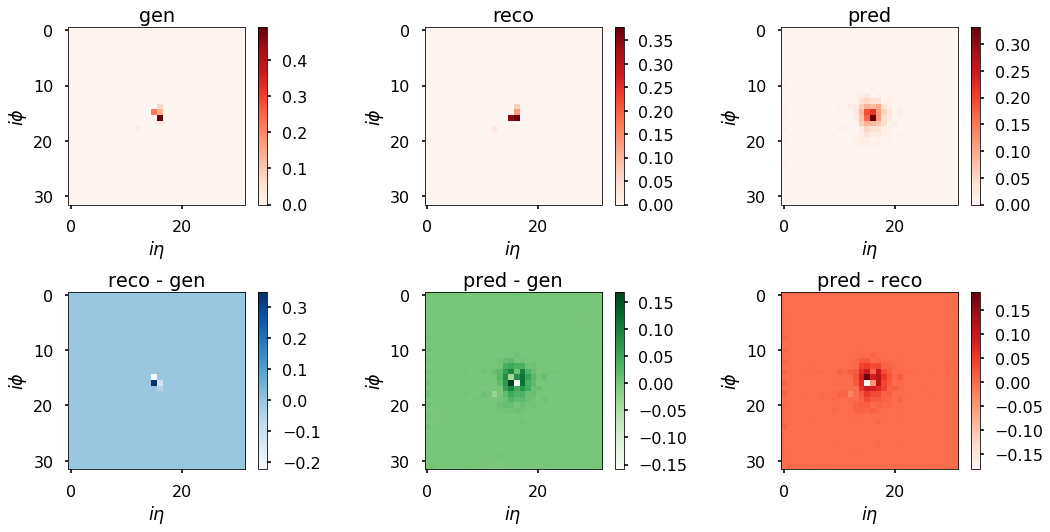

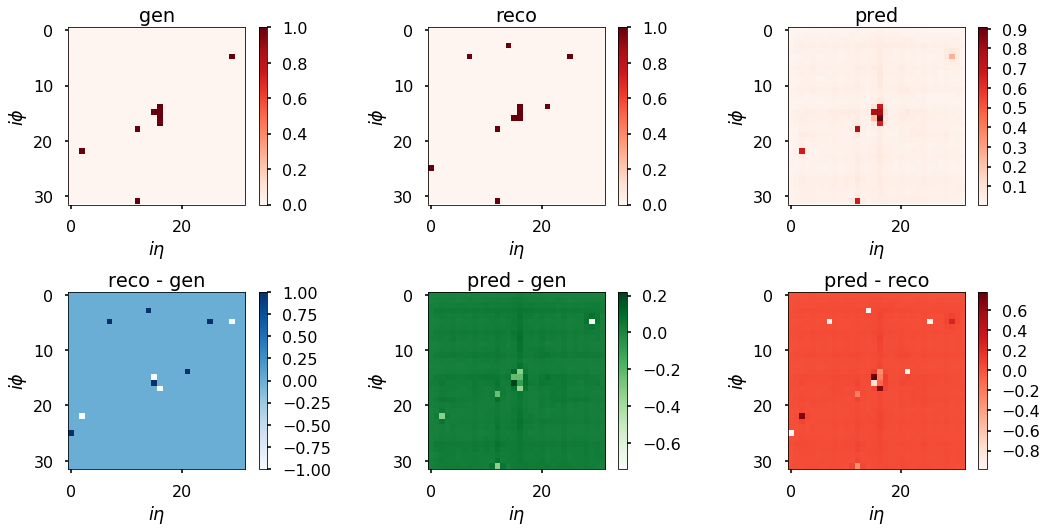

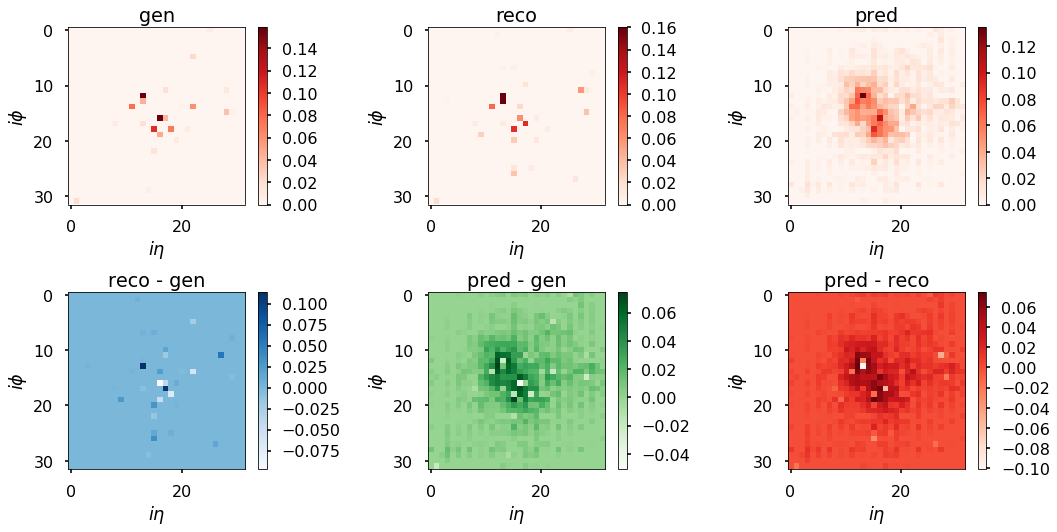

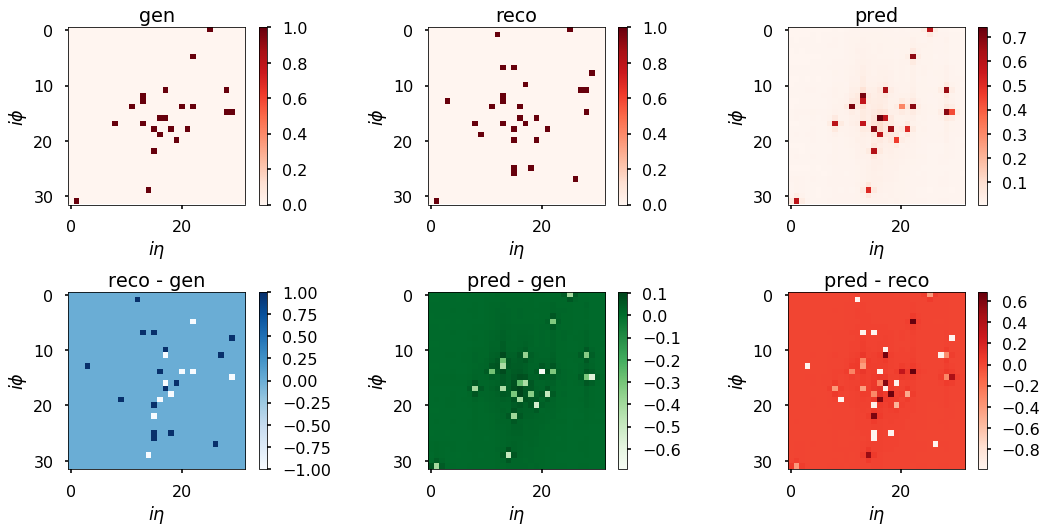

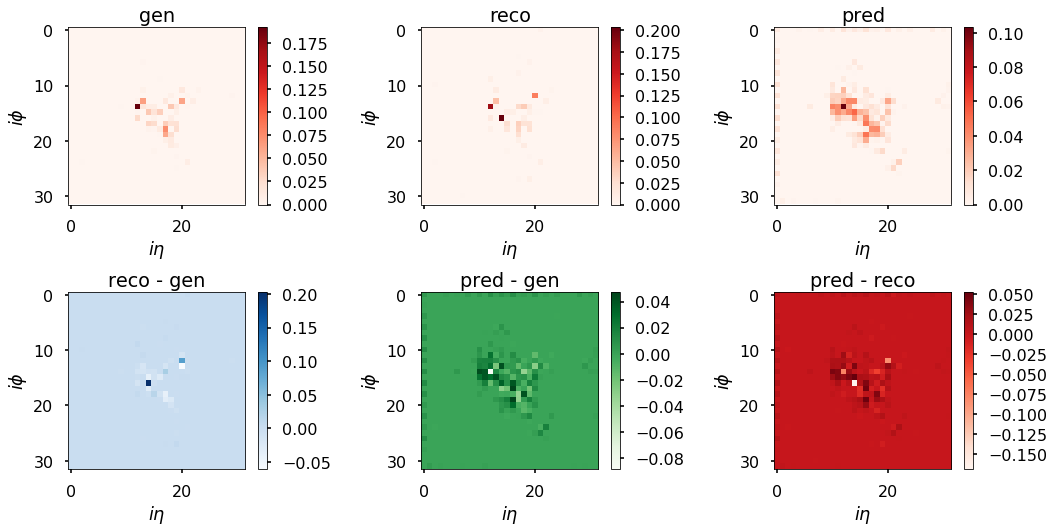

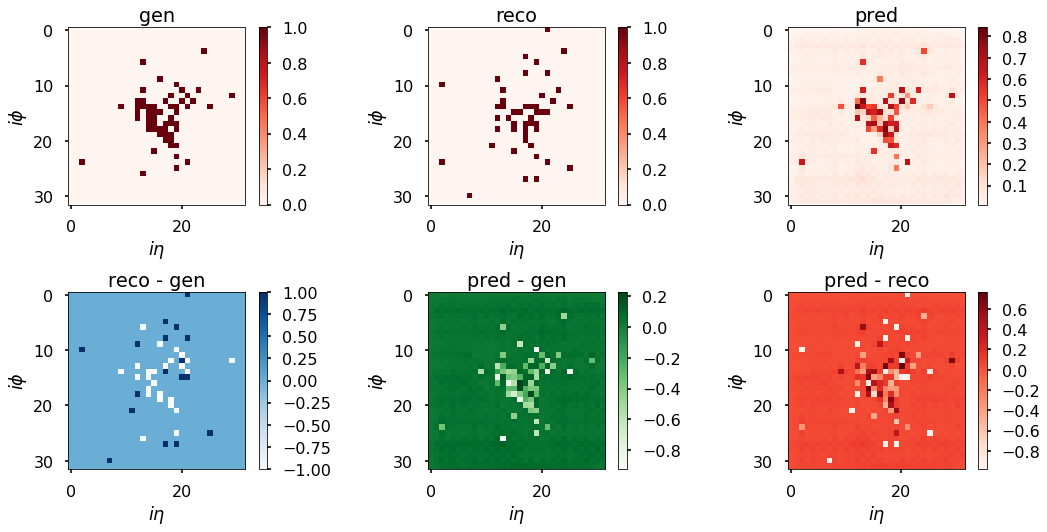

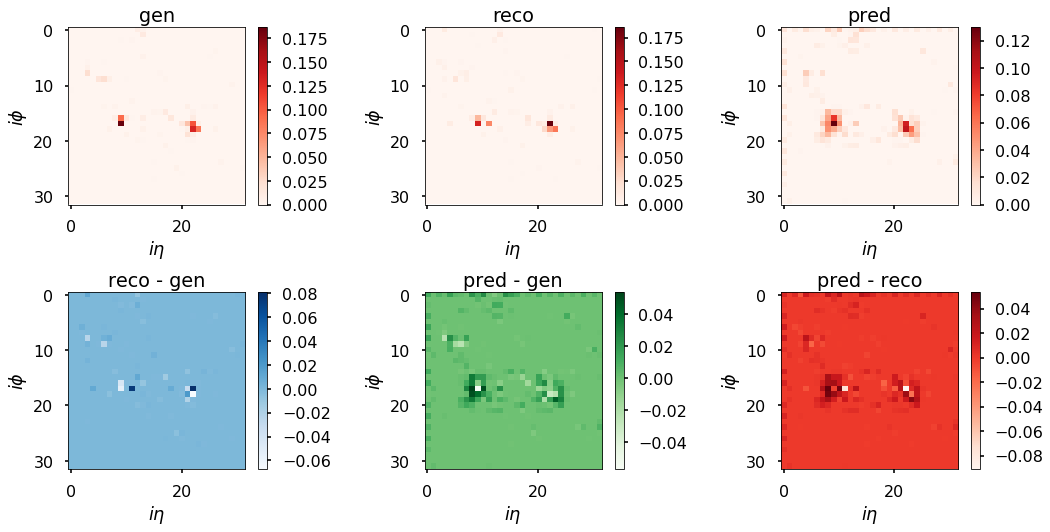

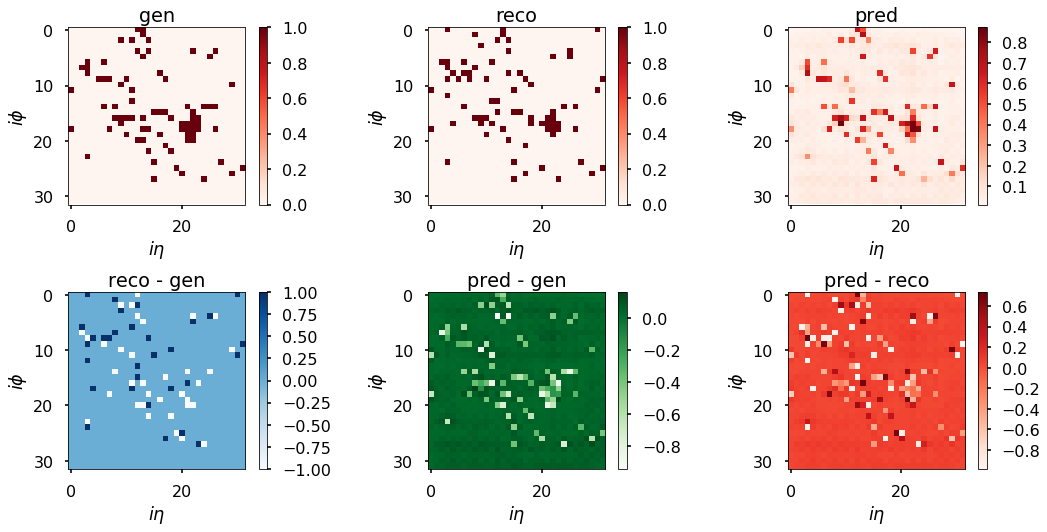

In [127]:
reload(plotting)
for img in sample:
    plotting.show_prediction(img,X_unnorm[:,:32,:32],y_test[:,:32,:32],y_pred_val)
    plt.savefig('plots/%s/jet_pred_val_%d.png' % (target,img))
    if y_pred_prob is not None:
        plotting.show_prediction(img,np.greater(X_unnorm[:,:32,:32],0.).astype(np.float32),np.greater(y_test[:,:32,:32],0.).astype(np.float32),y_pred_prob)
        plt.savefig('plots/%s/jet_pred_mask_%d.png' % (target,img))

In [128]:
def generate_jets(pred_val,pred_prob,rescale=True):
    pred = pred_val*(np.random.uniform(size=pred_val.shape) < pred_prob)
    if rescale:
        pred_scl = np.sum(pred_val*pred_prob,axis=(1,2),keepdims=True)/np.sum(pred,axis=(1,2),keepdims=True)
        pred *= pred_scl
    return pred

gen = X_unnorm[:y_pred_val.shape[0],:32,:32,:]
reco = y_test[:y_pred_val.shape[0],:32,:32,:]
if y_pred_prob is not None:
    pred_noscl  = generate_jets(y_pred_val,y_pred_prob,False)
    pred  = generate_jets(y_pred_val,y_pred_prob)
    pred1 = generate_jets(y_pred_val,y_pred_prob)
    pred2 = generate_jets(y_pred_val,y_pred_prob)
    pred3 = generate_jets(y_pred_val,y_pred_prob)
    pred4 = generate_jets(y_pred_val,y_pred_prob)
else:
    pred = y_pred_val


48973


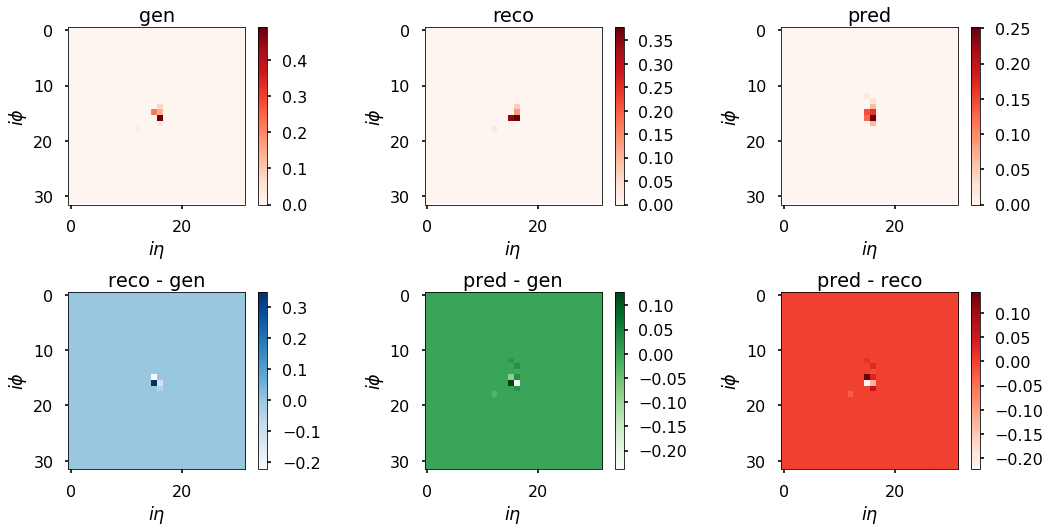

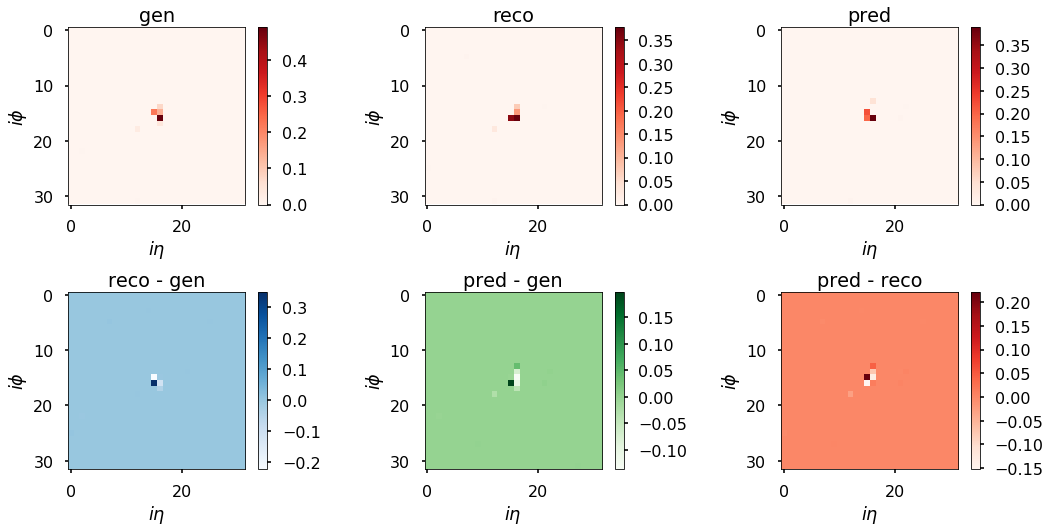

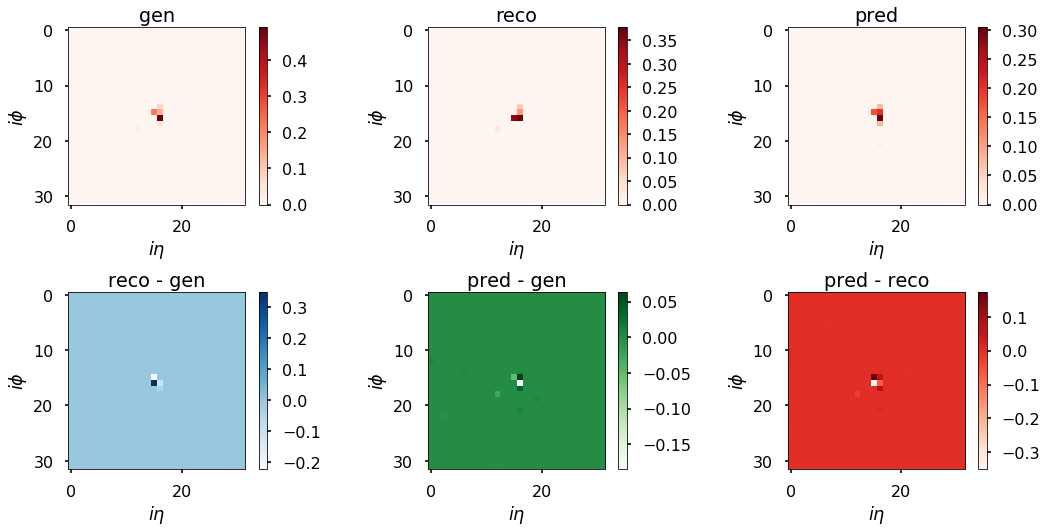

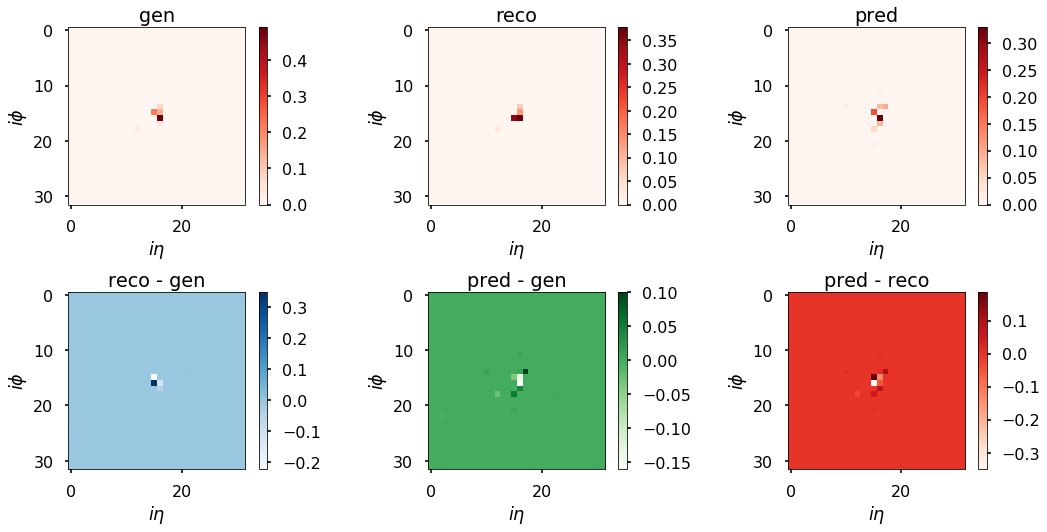

39524


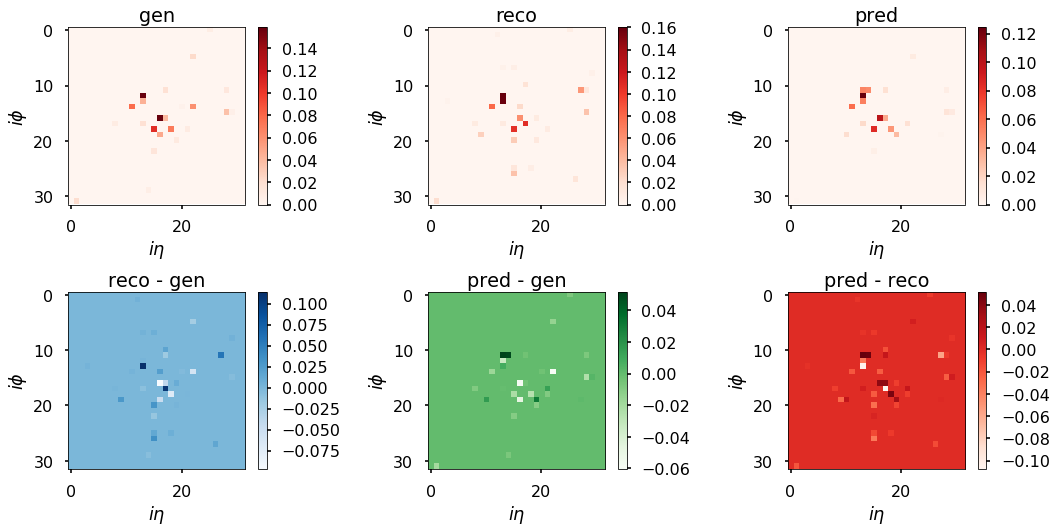

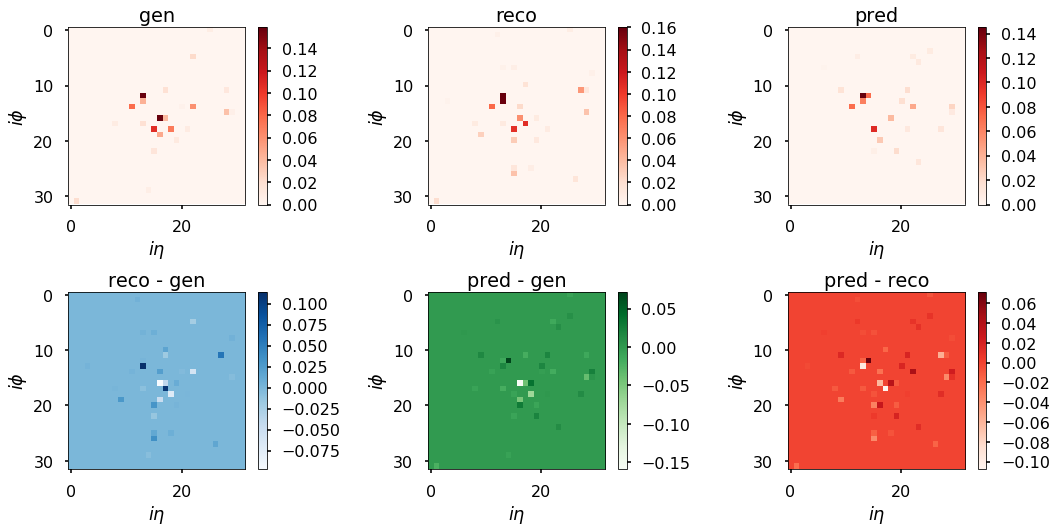

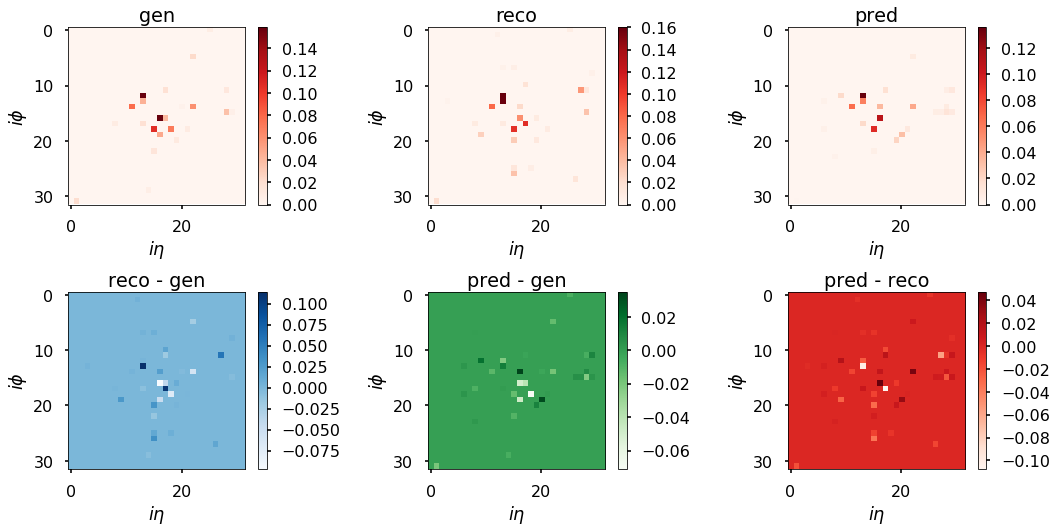

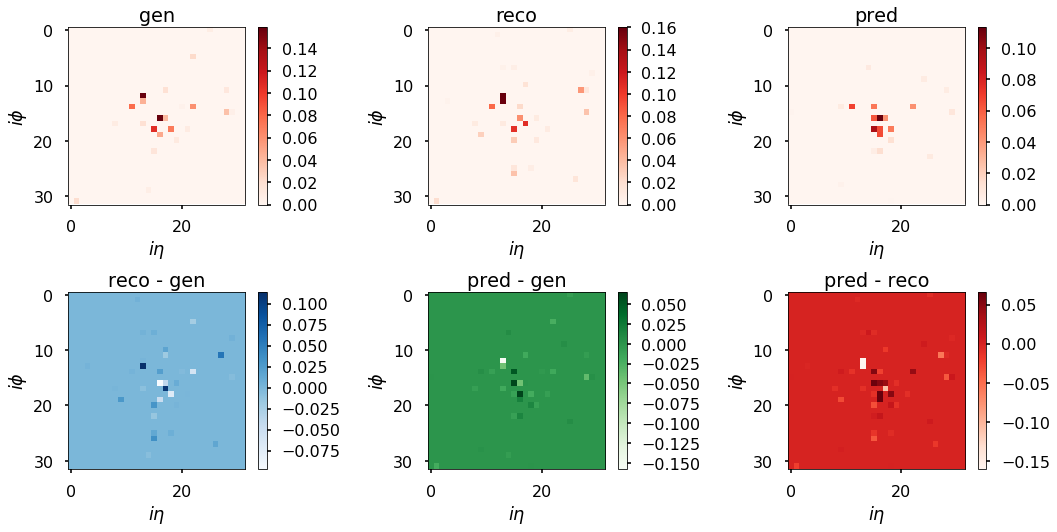

67881


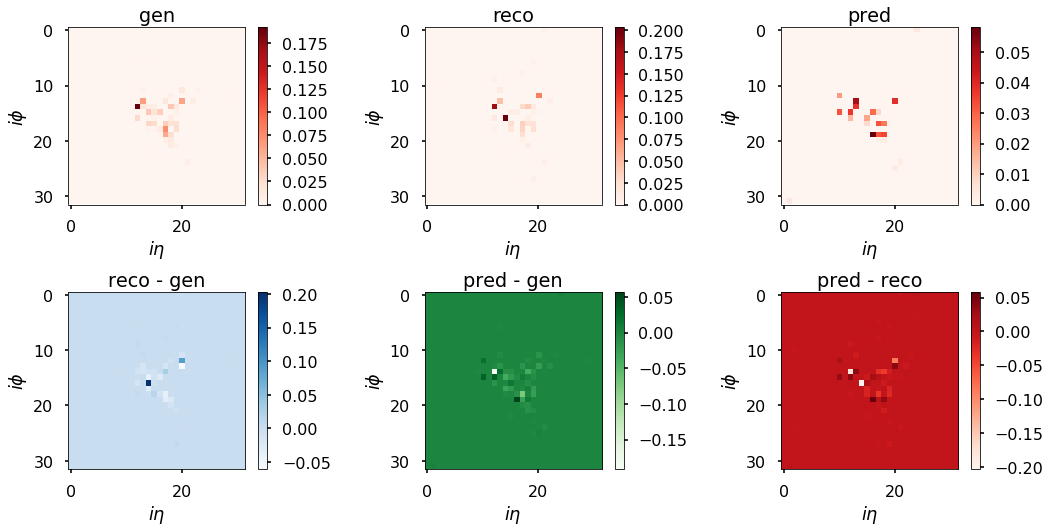

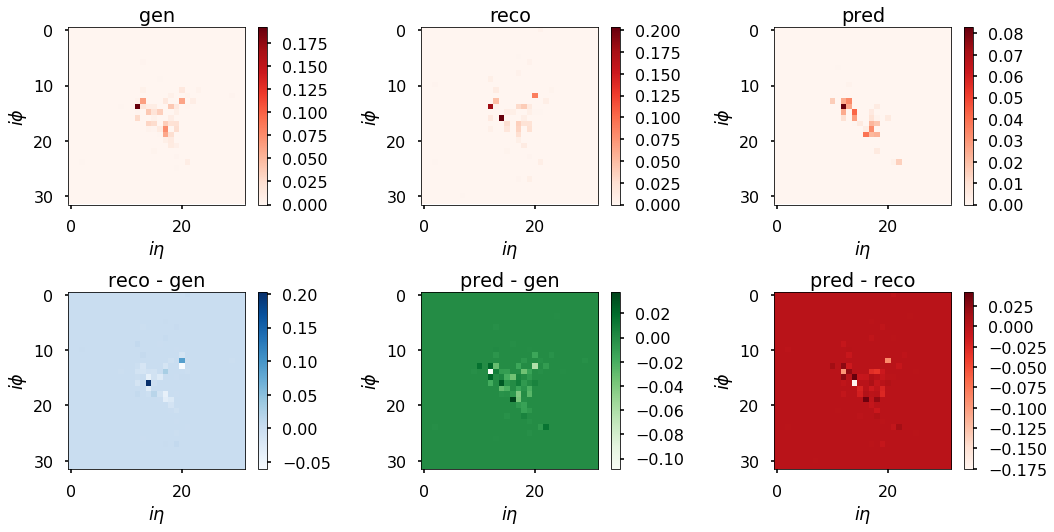

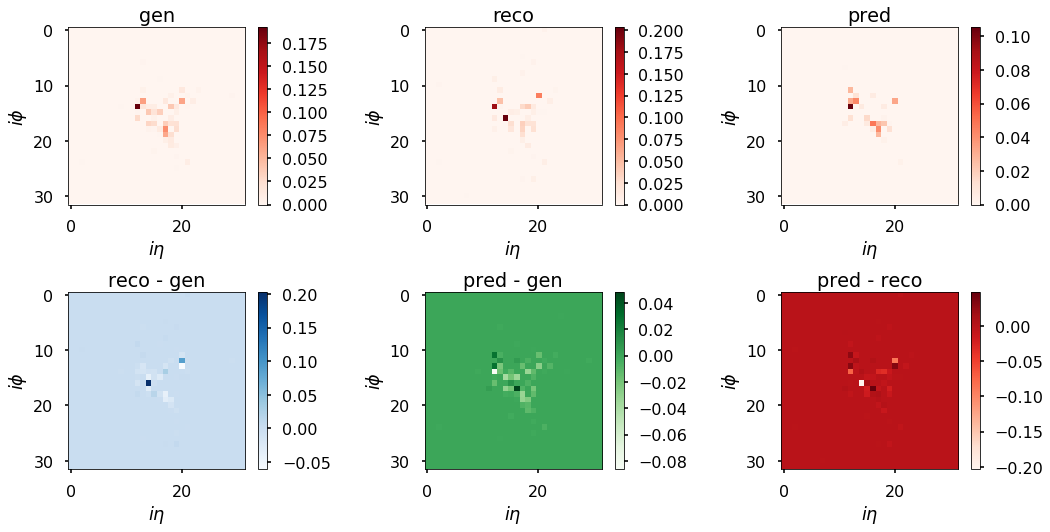

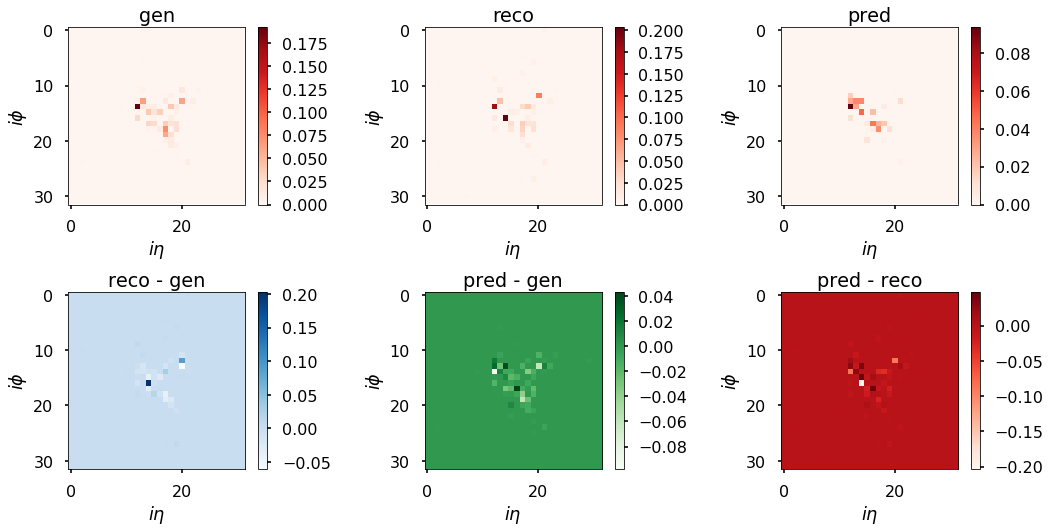

67532


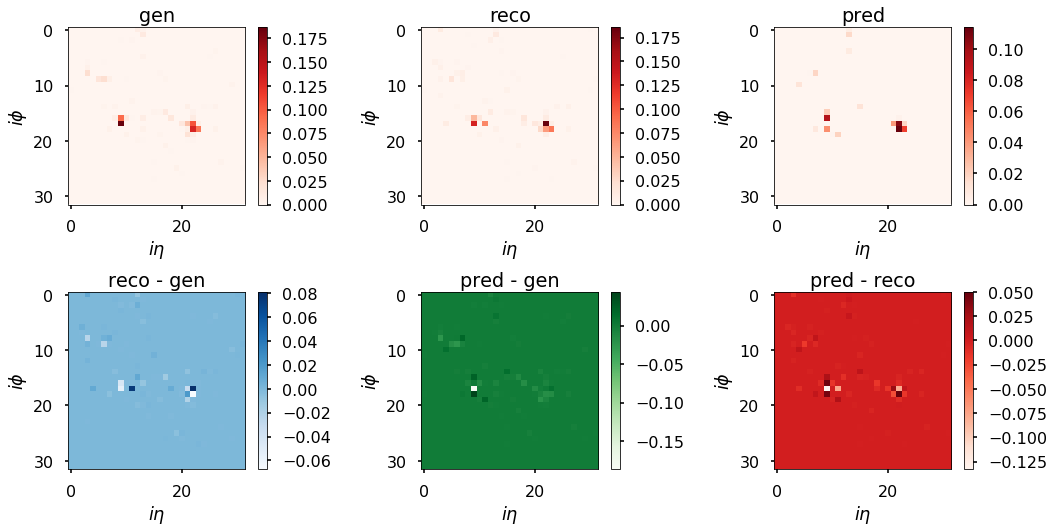

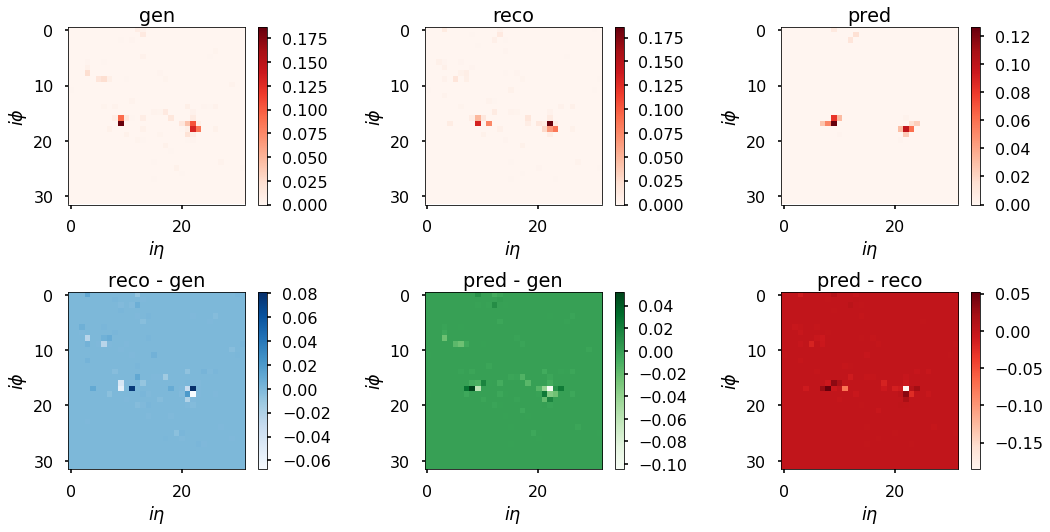

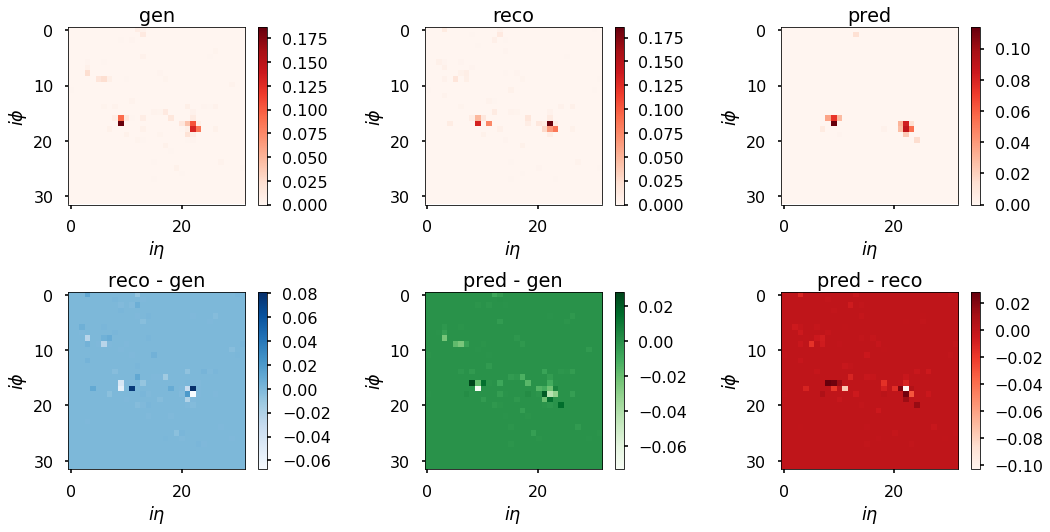

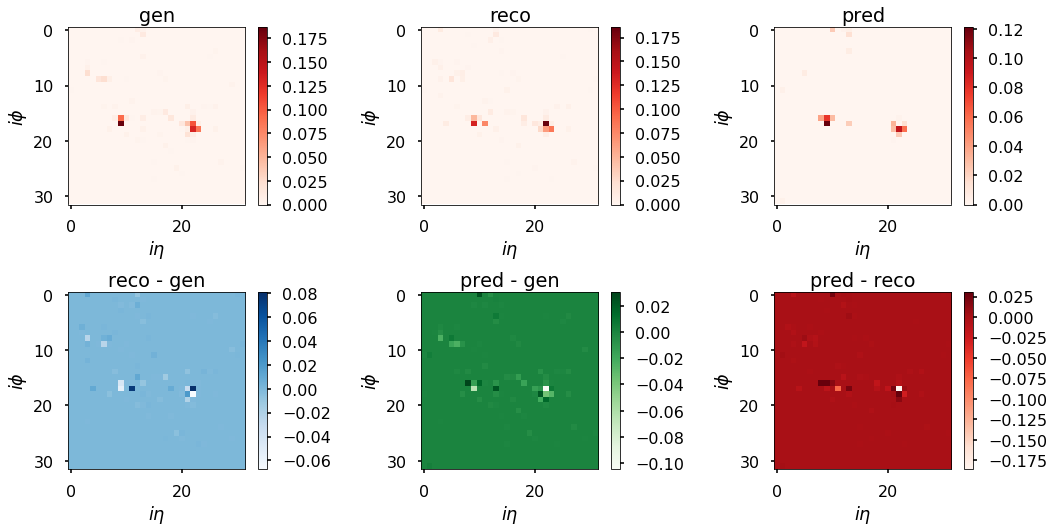

In [129]:
if y_pred_prob is not None:
    for img in sample:
        print(img)
        for ip,ipred in enumerate([pred1,pred2,pred3,pred4]):
            plotting.show_prediction(img,gen,reco,ipred)
            plt.savefig('plots/%s/jet_pred%d_%d.png' % (target,ip+1,img))
            plt.show()

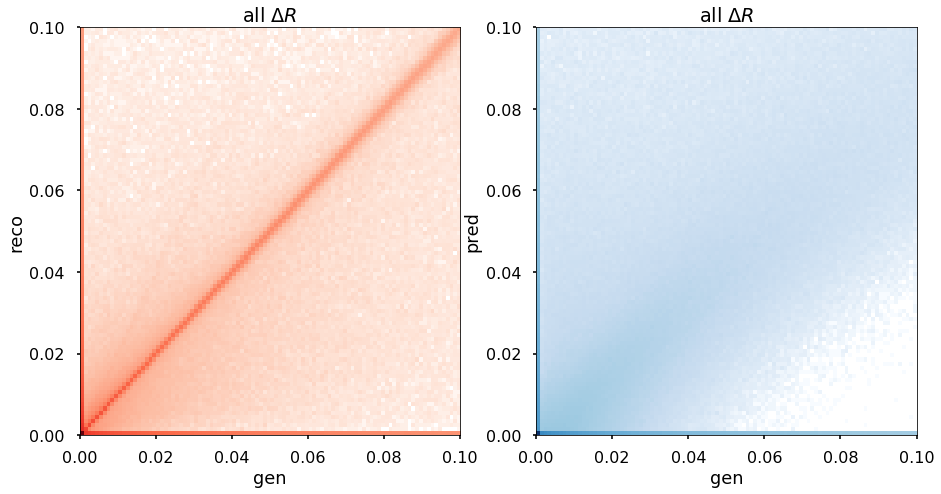

In [130]:
from matplotlib.colors import LogNorm 

reload(plotting)
plotting.scatter_pred(gen,reco,pred,None,title='all $\Delta R$')
plt.savefig('plots/%s/scatter_pred.png' % target)

In [131]:
rings, ring_masks = plotting.make_masks([0.3, 0.2, 0.15, 0.1, 0.05, 0.])

$0.000000 \leq \Delta R \lt 0.050000$
$0.050000 \leq \Delta R \lt 0.100000$
$0.100000 \leq \Delta R \lt 0.150000$
$0.150000 \leq \Delta R \lt 0.200000$
$0.200000 \leq \Delta R \lt 0.300000$


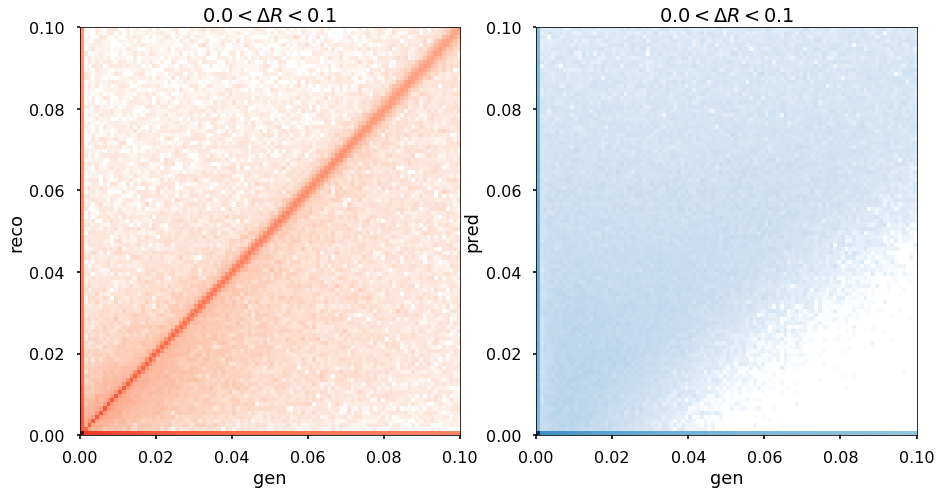

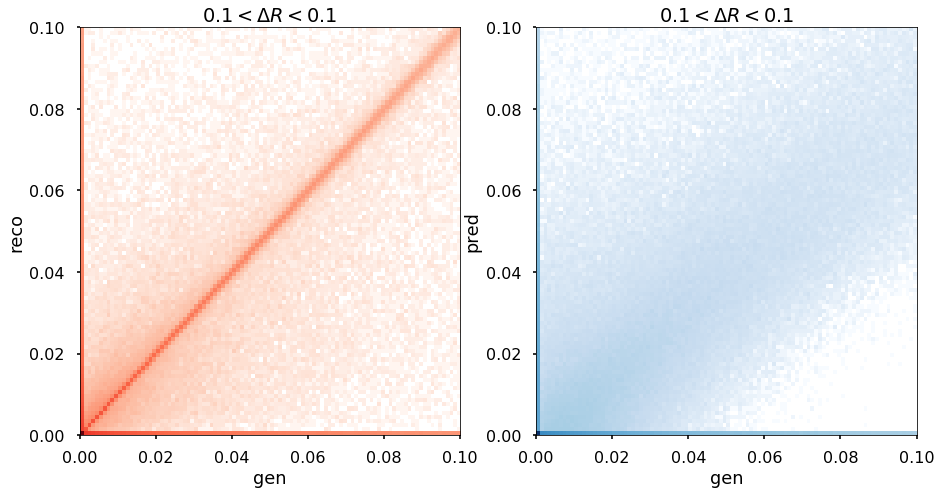

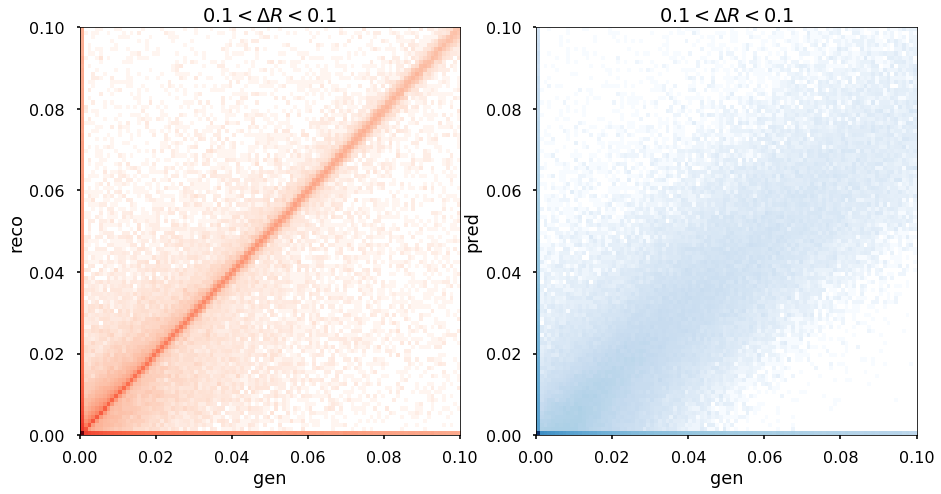

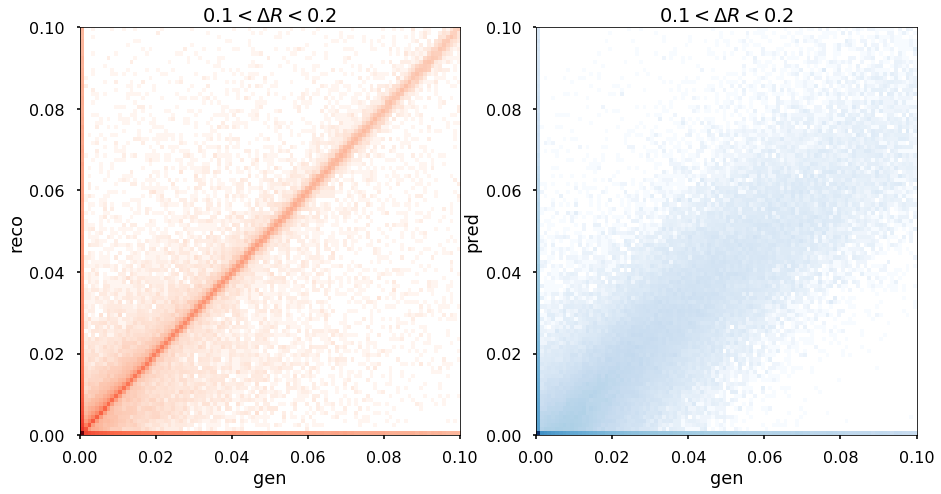

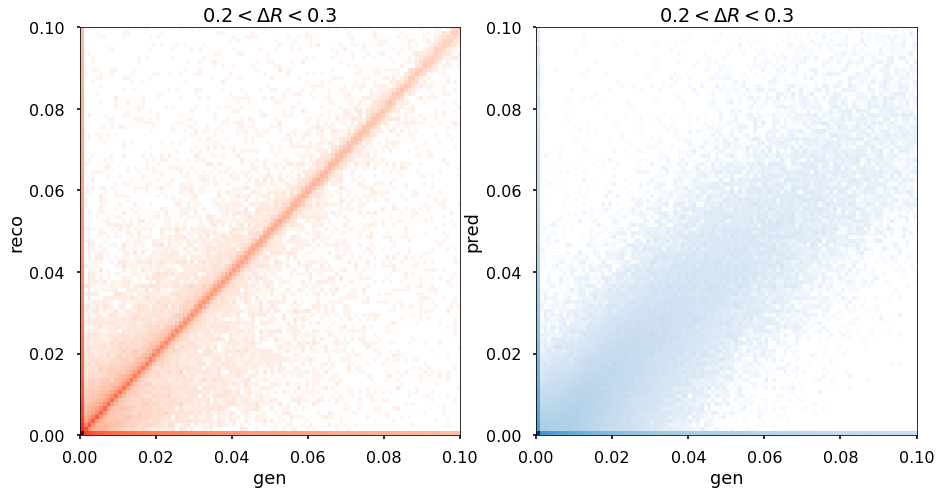

In [132]:
for iring,(ring,mask) in enumerate(zip(rings,ring_masks)):
    print("$%f \leq \Delta R \lt %f$" % ring )
    plotting.scatter_pred(gen,reco,pred,mask,title="$%1.1f < \Delta R < %1.1f$" % ring )
    plt.savefig('plots/%s/scatter_pred_%d.png' % (target, iring ) )

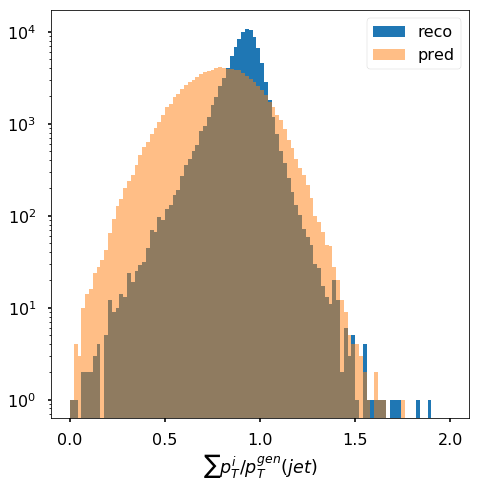

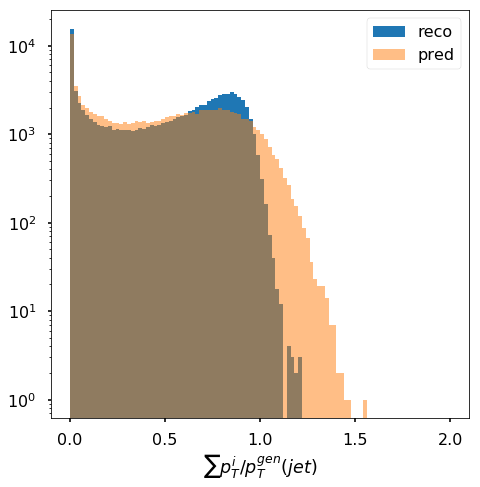

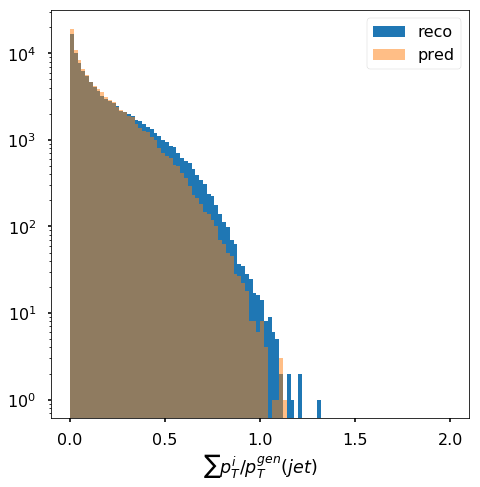

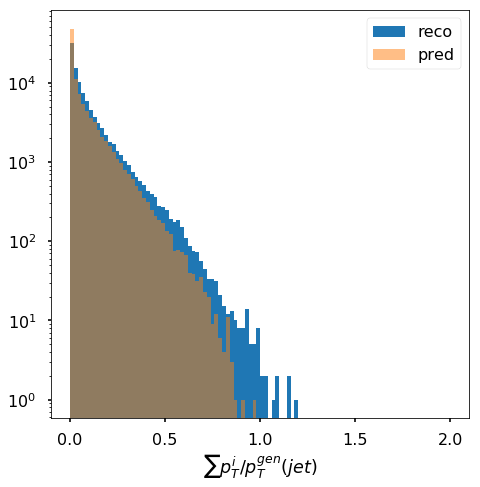

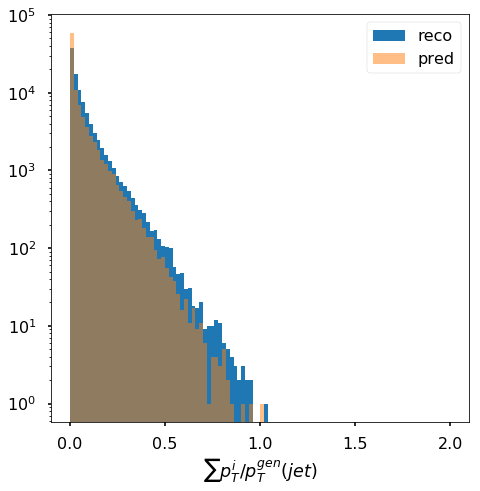

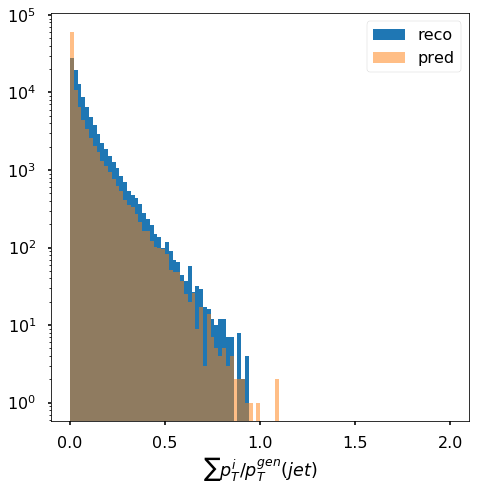

In [133]:
plotting.distrib_pred(gen,reco,pred_noscl,title='all $\Delta R$')
plt.savefig('plots/%s/sum_pred.png' % target)
for iring,(ring,mask) in enumerate(zip(rings,ring_masks)):
    plotting.distrib_pred(gen,reco,pred_noscl,mask,title="$%1.1f < \Delta R < %1.1f$" % ring )
    plt.savefig('plots/%s/sum_pred_%d.png' % (target, iring ) )

In [134]:
cond = inputs_test[2][:pred.shape[0]]
weights = w_test[:pred.shape[0]]

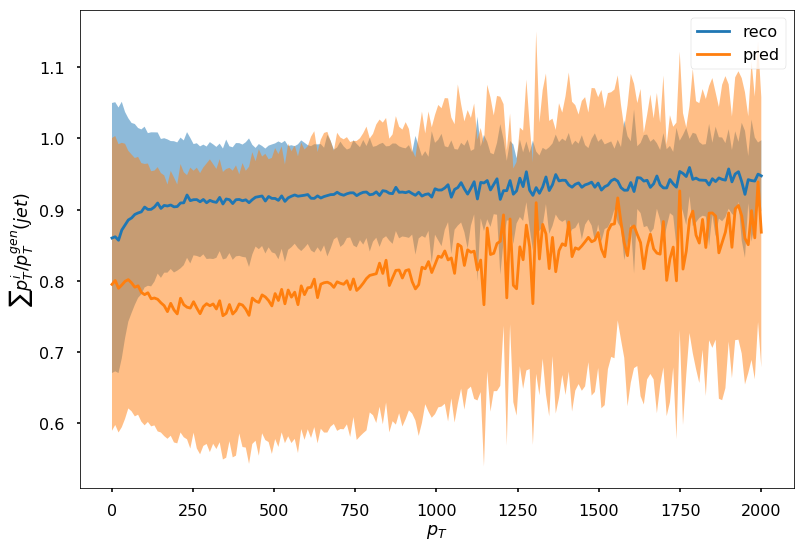

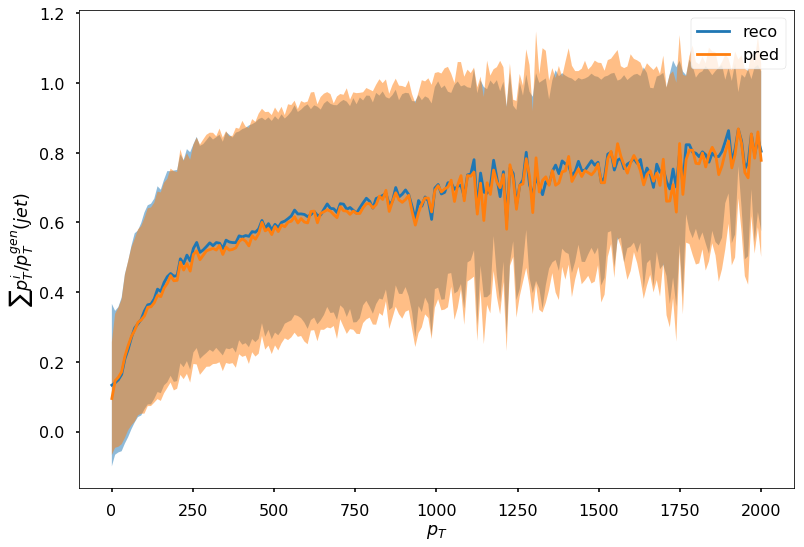

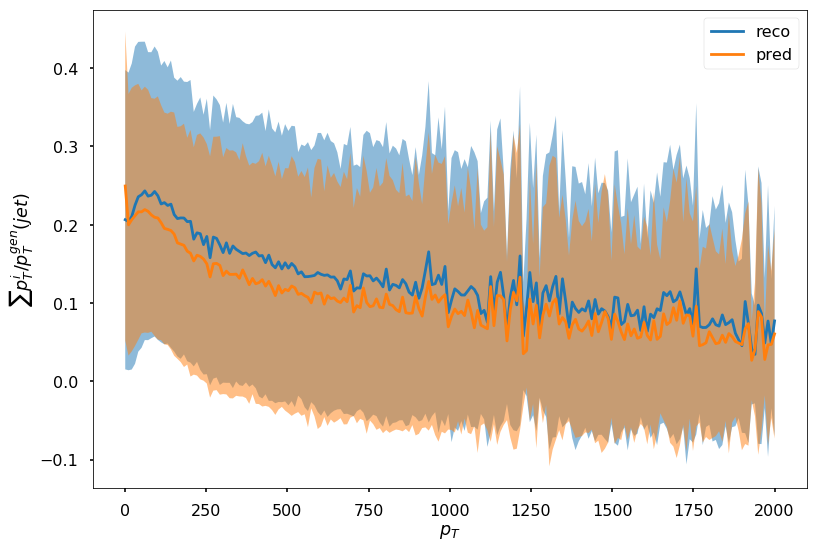

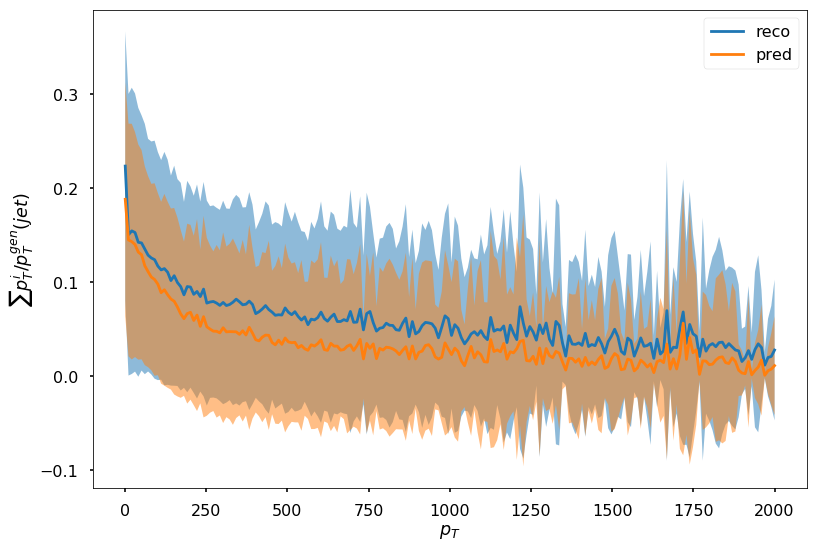

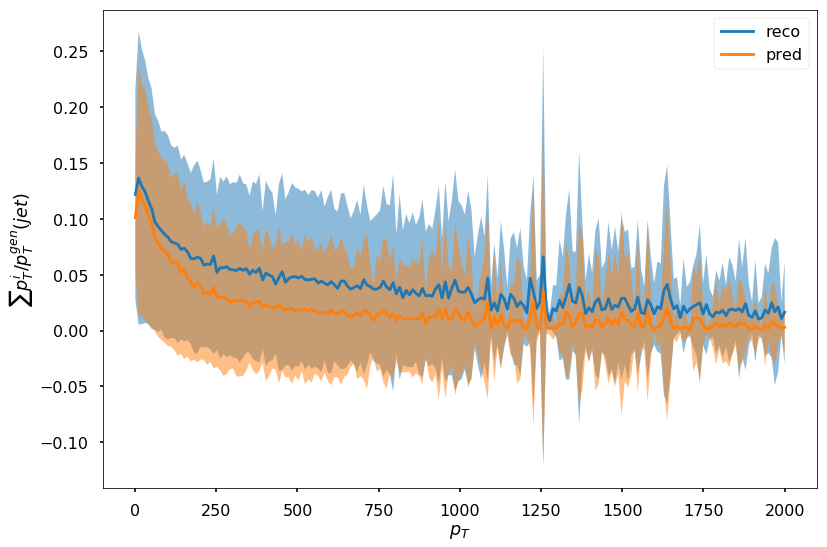

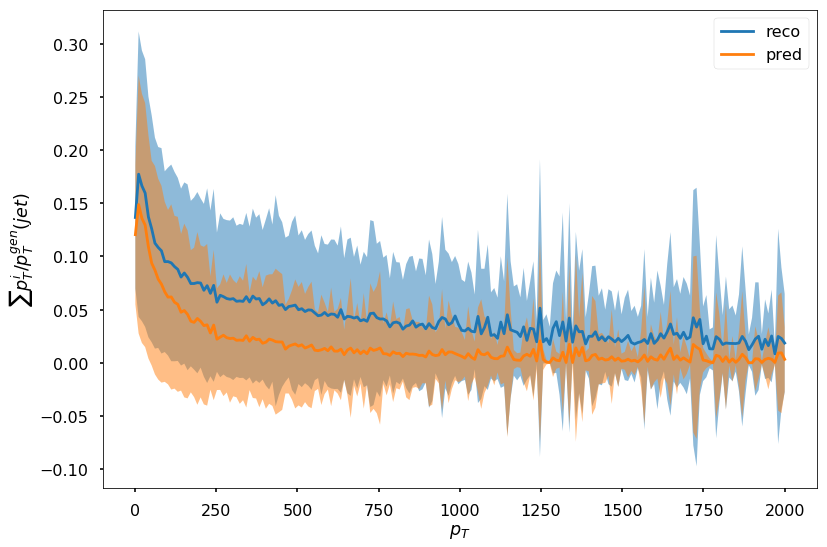

In [135]:
plotting.show_moments(reco,pred_noscl,cond[:,0,0],np.linspace(1,2000,200),xlabel='$p_T$',weights=weights)
plt.savefig('plots/%s/pt_dep_pred.png' % target)
plt.show()
for iring,(ring,mask) in enumerate(zip(rings,ring_masks)):
    #distrib_pred(gen,reco,pred,mask)
    plotting.show_moments(reco,pred_noscl,cond[:,0,0],np.linspace(1,2000,200),mask=mask,xlabel='$p_T$',weights=weights)
    plt.savefig('plots/%s/pt_dep_pred_%d.png' % (target,iring) )
    plt.show()

In [136]:
# pred_axis_x = (pred[:,:,:,0] * x).sum(axis=(1,2)) / pred[:,:,:,0].sum(axis=(1,2))
# pred_axis_y = (pred[:,:,:,0] * y).sum(axis=(1,2)) / pred[:,:,:,0].sum(axis=(1,2))

In [137]:
# reco_axis_x = (reco[:,:,:,0] * x).sum(axis=(1,2)) / reco[:,:,:,0].sum(axis=(1,2))
# reco_axis_y = (reco[:,:,:,0] * y).sum(axis=(1,2)) / reco[:,:,:,0].sum(axis=(1,2))

In [138]:
# gen_axis_x = (gen[:,:,:,0] * x).sum(axis=(1,2)) / gen[:,:,:,0].sum(axis=(1,2))
# gen_axis_y = (gen[:,:,:,0] * y).sum(axis=(1,2)) / gen[:,:,:,0].sum(axis=(1,2))

In [139]:
# plt.figure(figsize=(15,7.5))
# plt.subplot(121)
# plt.hist2d(pred_axis_x-gen_axis_x,pred_axis_y-gen_axis_y,bins=100,cmap='Blues',range=[[-2,2],[-2,2]],norm=LogNorm());
# plt.subplot(122)
# plt.hist2d(reco_axis_x-gen_axis_x,reco_axis_y-gen_axis_y,bins=100,cmap='Reds',alpha=0.5,range=[[-2,2],[-2,2]],norm=LogNorm());